# 02 Train Inference Models

In [1]:
import glob
import numpy as np
from skimage import io
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

import wandb

import torch
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

%load_ext autoreload
%autoreload 2
from venomai import unet, loader, metrics, predictor, preprocess

In [2]:
project_name = 'VenomAI-Necrosis-UNet-Inference'
model_path = 'models/'
model_name = 'unet_inference'

epochs = 1
batch_size = 32
lr = 0.0001

In [3]:
def setup_loaders(split_index, random_seed=15496):
    images, masks = loader.load_preprocessed_data()

    kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)

    i = 0
    for train_idx, val_idx in kf.split(images):
        if split_index == i:
            break
        i += 1

    val_images = [images[i] for i in val_idx]
    val_masks = [masks[i] for i in val_idx]

    train_images = [images[i] for i in train_idx]
    train_masks = [masks[i] for i in train_idx]

    train_dataset = loader.UNetLoader(train_images,
                               train_masks,            
                               input_size=256,
                               training=True,
                               augment=True)
    val_dataset = loader.UNetLoader(val_images,
                             val_masks,
                             input_size=256,
                             training=False,
                             augment=False)

    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=0)
    val_loader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=0)
    return train_loader, val_loader


In [4]:
for i in range(5):

    train_loader, val_loader = setup_loaders(i)
    
    # Setup wandb logger
    wandb_logger = WandbLogger(name=f'Inference_{i}', project=project_name, log_model=False)

    # Save best model callback
    checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=model_path,
                                                       filename=f'{model_name}_{i}',
                                                       monitor="val/mcc_ce_loss",
                                                       mode="min")

    # Stochastic weight averaging callback
    swa_callback = pl.callbacks.StochasticWeightAveraging(swa_epoch_start=0.75,
                                                          swa_lrs=0.05,
                                                          annealing_epochs=10,
                                                          annealing_strategy='cos')

    # Load model
    model = unet.UNet(lr=lr, num_channels=3, num_classes=3)

    # Train model
    model.train()
    trainer = pl.Trainer(max_epochs=epochs,
                         log_every_n_steps=1,
                         logger=wandb_logger,
                         callbacks=[checkpoint_callback, swa_callback],
                         gpus=1,
                         accelerator="gpu")
    trainer.fit(model, train_loader, val_loader)
    
    wandb.finish()
    
    del model, trainer, train_loader, val_loader

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: willap. Use `wandb login --relogin` to force relogin


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name    | Type          | Params
-------------------------------------------
0  | d1      | UNetDownBlock | 39.0 K
1  | d2      | UNetDownBlock | 221 K 
2  | d3      | UNetDownBlock | 886 K 
3  | d4      | UNetDownBlock | 3.5 M 
4  | d5      | UNetDownBlock | 14.2 M
5  | u1      | UNetUpBlock   | 9.2 M 
6  | u2      | UNetUpBlock   | 2.3 M 
7  | u3      | UNetUpBlock   | 574 K 
8  | u4      | UNetUpBlock   | 143 K 
9  | conv    | Conv2d        | 1.7 K 
10 | softmax | Softmax       | 0     
-------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.188   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\Billy\anaconda3\envs\venom-ai\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Billy\anaconda3\envs\venom-ai\lib\site-packages\torch\nn\modules\conv.py:443: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:744.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Users\Billy\anaconda3\envs\venom-ai\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottlen

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
train/accuracy,▁▁▁▂▂▂▅▅▇▆▆▆▇▇██▇▇██▁▂▂▃▆▆▆▆▇▇▇▆█▇▇▇████
train/dice,▁▂▂▂▂▂▅▅▇▆▆▅▅▆▅█▆▆▆▆▁▂▂▃▅▅▅▅▆▆▅▅▆▇▅▆▇▇█▆
train/iou,▁▂▁▂▂▂▄▅▆▆▅▄▅▆▅█▅▅▆▆▁▂▂▂▄▅▄▄▅▆▄▅▅▇▄▆▇▆█▆
train/mcc,▁▃▃▃▃▃▄▅▆▅▅▃▄▅▄▇▅▅▅▅▁▂▂▂▃▄▄▃▅▅▃▄▅▇▃▅▇▆█▆
train/mcc_ce_loss,█▇▇▇▆▆▅▅▅▄▄▆▅▄▄▂▄▄▃▃█▇▇▇▅▅▅▅▄▄▅▅▃▂▄▄▁▂▁▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val/accuracy,█▁
val/dice,█▁
val/iou,█▁
val/mcc,█▁


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Billy\anaconda3\envs\venom-ai\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:611: UserWarning: Checkpoint directory C:\Users\Billy\Desktop\Work\venom-ai\NERD-Experiments\models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name    | Type          | Params
-------------------------------------------
0  | d1      | UNetDownBlock | 39.0 K
1  | d2      | UNetDownBlock | 221 K 
2  | d3      | UNetDownBlock | 886 K 
3  | d4      | UNetDownBlock | 3.5 M 
4  | d5      | UNetDownBlock | 14.2 M
5  | u1      | UNetUpBlock   | 9.2 M 
6  | u2      | UNetUpBlock   | 2.3 M 
7  | u3      | UNetUpBlock   | 574 K 
8  | u4      | UNetUpBlock   | 143 K 
9  | conv    | Conv2d        | 1.7 K 
10 | softmax | Softmax       | 0     
-----

Sanity Checking: 0it [00:00, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 1.01 GiB (GPU 0; 24.00 GiB total capacity; 2.59 GiB already allocated; 16.66 GiB free; 4.79 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [3]:
images, masks = loader.load_preprocessed_data()

In [4]:
random_seed = 46

split_index = 0

kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)

i = 0
for train_idx, val_idx in kf.split(images):
    if split_index == i:
        break
    i += 1

val_images = [images[i] for i in val_idx]
val_masks = [masks[i] for i in val_idx]

train_images = [images[i] for i in train_idx]
train_masks = [masks[i] for i in train_idx]

In [5]:
# train_image_patches, train_mask_patches = loader.extract_all_patches(train_images, train_masks)
# val_image_patches, val_mask_patches = loader.extract_all_patches(val_images, val_masks)

In [6]:
# data = np.array([train_image_patches, train_mask_patches, val_image_patches, val_mask_patches], dtype=object)
# np.save('train_image_patches.npy', train_image_patches)
# np.save('train_mask_patches.npy', train_mask_patches)
# np.save('val_image_patches.npy', val_image_patches)
# np.save('val_mask_patches.npy', val_mask_patches)

In [7]:
train_image_patches = np.load('train_image_patches.npy')
train_mask_patches = np.load('train_mask_patches.npy')
val_image_patches = np.load('val_image_patches.npy')
val_mask_patches = np.load('val_mask_patches.npy')

In [8]:
train_dataset = loader.UNetLoader(train_image_patches,
                           train_mask_patches,            
                           input_size=256,
                           training=True,
                           augment=True)
val_dataset = loader.UNetLoader(val_image_patches,
                         val_mask_patches,
                         input_size=256,
                         training=False,
                         augment=False)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=0)

In [9]:
# wandb.finish()

In [11]:
i = 0

# Setup wandb logger
wandb_logger = WandbLogger(name=f'Inference_{i}', project=project_name, log_model=False)

# Save best model callback
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=model_path,
                                                   filename=f'{model_name}_{i}',
                                                   monitor="val/mcc_ce_loss",
                                                   mode="min")

# Stochastic weight averaging callback
swa_callback = pl.callbacks.StochasticWeightAveraging(swa_epoch_start=0.75,
                                                      swa_lrs=0.05,
                                                      annealing_epochs=10,
                                                      annealing_strategy='cos')

# Load model
model = unet.UNet(lr=lr, num_channels=3, num_classes=3)

# Train model
model.train()
trainer = pl.Trainer(max_epochs=epochs,
                     log_every_n_steps=1,
                     logger=wandb_logger,
                     callbacks=[checkpoint_callback, swa_callback],
                     gpus=1,
                     accelerator="gpu")
trainer.fit(model, train_loader, val_loader)

wandb.finish()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name    | Type          | Params
-------------------------------------------
0  | d1      | UNetDownBlock | 39.0 K
1  | d2      | UNetDownBlock | 221 K 
2  | d3      | UNetDownBlock | 886 K 
3  | d4      | UNetDownBlock | 3.5 M 
4  | d5      | UNetDownBlock | 14.2 M
5  | u1      | UNetUpBlock   | 9.2 M 
6  | u2      | UNetUpBlock   | 2.3 M 
7  | u3      | UNetUpBlock   | 574 K 
8  | u4      | UNetUpBlock   | 143 K 
9  | conv    | Conv2d        | 1.7 K 
10 | softmax | Softmax       | 0     
-------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.188   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/accuracy,▁▂▂▂▂▃▃▃▃▃▄▆▅▆▆▆▅▆▇▇▇▇▇▇█▇▇████▇████████
train/dice,▁▂▃▂▂▃▃▃▂▃▄▅▄▅▅▆▅▆▆▅▆▆▅▅▆▆▆▆▇█▇▇▇▇▇▇▆▆▇▇
train/iou,▁▂▂▂▂▂▃▂▂▂▄▄▄▅▅▆▅▅▆▅▆▅▅▅▆▅▆▆▇█▇▆▆▆▇▇▆▅▇▇
train/mcc,▁▂▃▃▄▄▄▃▃▄▄▄▄▅▅▆▅▅▆▄▆▅▄▅▆▅▆▅▇█▇▆▇▆▇▇▆▅▆█
train/mcc_ce_loss,█▇▇▇▆▆▆▆▇▆▅▅▅▅▅▅▅▆▄▅▄▅▅▄▃▄▃▄▂▃▂▃▃▂▂▂▃▃▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,0
train/accuracy,0.96079
train/dice,0.51546
train/iou,0.34722


In [11]:
trainer.save_checkpoint("models/final_inference_0.ckpt")

In [15]:
labels_1 = np.argwhere(np.sum(val_mask_patches[:,:,:,0,:], axis=(1,2,3)) > 0).ravel()
labels_2 = np.argwhere(np.sum(val_mask_patches[:,:,:,2,:], axis=(1,2,3)) > 0).ravel()

In [64]:
# model = unet.UNet(lr=lr, num_channels=3, num_classes=3).load_from_checkpoint(checkpoint_path="models/unet_inference_0.ckpt")
model = unet.UNet(lr=lr, num_channels=3, num_classes=3).load_from_checkpoint(checkpoint_path="models/final_inference_0.ckpt")
model.cuda()
model.eval()

UNet(
  (d1): UNetDownBlock(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (convblock): UNetConvBlock(
      (convblock): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): ReLU()
        (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (d2): UNetDownBlock(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (convblock): UNetConvBlock(
      (convblock): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): ReLU()
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), str

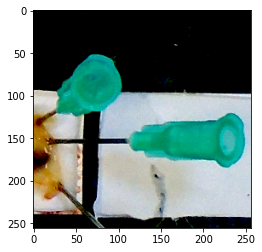

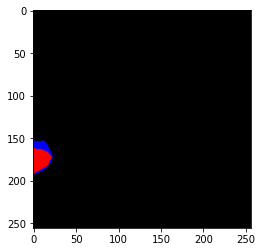

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


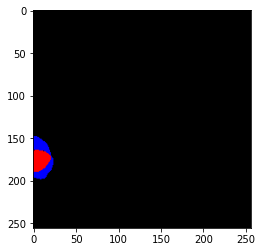

In [73]:
i = 12
j = 0

image = val_image_patches[labels_1[i]]
mask = ((val_mask_patches[labels_1[i],:,:,:,j] / 255) > 0) * 255
weight = mask * 0 + 255

image_tensor = torch.tensor(np.moveaxis(image / 255, -1, 0)[None,:,:,:].astype('float32')).cuda()
pred_raw = model(image_tensor)[0].detach().cpu().numpy()

pred = np.zeros((256,256,3))
pred[:,:,0] = ((pred_raw[2] > 0.5) * 255).astype('uint8')
pred[:,:,2] = ((pred_raw[1] > 0.5) * 255).astype('uint8')

plt.imshow(image)
plt.show()
plt.imshow(mask)
plt.show()
plt.imshow(pred)
plt.show()